In [1]:
%load_ext autoreload
%autoreload 2
import json
from scipy import sparse
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import string
import scipy.stats as stats

# We must run scripts on Terrier with the parameters!

### So we run:

* Run the weights and queries in Terrier to get the reuslts file
    - bash clef-run-top5-idf-p-alpha.sh and variants (in terrier-core-4.2)
    - bin/trec_terrier.sh -r -Dtrec.model=models.BM25PAlpha  -Dbm25p.p=\$p -Dbm25p.alpha=\$alpha -Dbm25p.w
* Use trec_eval tool

# How we do it

#### Scoring functions to evaluate:
    - BM25 
    - BM25P10-top5-idf 
    - BM25P10-top5-tfidf 
    - BM25P10-top10-idf 
    - BM25P10-top10-tfidf

For each scoring function result file we evaluate the 4 query types (A,B,C and D). We have some intermediate files from which we read the position of the corrent doc match. We evaluate if in top 1,10,100.

What are the metrics we are interested in?
- Win/loss ratio
- Average rank
- Precision @ 1,10,100
- MRR

There might be some queries in the input files with no results

## Load eval files

In [2]:
# Settings
dirEval = "./results-2005-2006/"
baseTypes = ["top5-idf", 
             "top5-tfidf",
             "top10-idf",
             "top10-tfidf"]
alphas = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
ending = ".eval"

### MRR plots for different alpha

In [3]:
def getMetric(file, metric):
    qidMetricVal = dict()   # to do : change to defaultdict, with 0 for MRR!!!
    with open(file) as inputFile:
        for line in inputFile:
            if metric in line:
                qidMetricVal[line.split()[1]] =float(line.split()[2])
    return qidMetricVal

In [4]:
# getMetric(dirEval+"BM25P-CLEF-FR-top5-idf-all-queries-p-10-alpha-15.res.eval", "recip") # HERE we change metric

In [12]:
import os

metric_dict = defaultdict()
for filename in os.listdir(dirEval):
    if ending in filename:
        print(filename)
        name_items = filename.split("-")
        baseType = name_items[3]+"-"+name_items[4]
        alpha = filename.split(".")[0].split("-")[11]
        metric_value_dict = getMetric(dirEval+filename, "recip") # HERE we change the metric
        metric_dict[(baseType, int(alpha))] = metric_value_dict["all"]

BM25P-CLEF-FR-top5-idf-2005-2006-queries-p-10-alpha-15.res.eval
BM25P-CLEF-FR-top5-idf-2005-2006-queries-p-10-alpha-40.res.eval
BM25P-CLEF-FR-top5-tfidf-2005-2006-queries-p-10-alpha-10.res.eval
BM25P-CLEF-FR-top5-tfidf-2005-2006-queries-p-10-alpha-40.res.eval
BM25P-CLEF-FR-top5-tfidf-2005-2006-queries-p-10-alpha-25.res.eval
BM25P-CLEF-FR-top10-tfidf-2005-2006-queries-p-10-alpha-15.res.eval
BM25P-CLEF-FR-top10-tfidf-2005-2006-queries-p-10-alpha-25.res.eval
BM25P-CLEF-FR-top5-idf-2005-2006-queries-p-10-alpha-1.res.eval
BM25P-CLEF-FR-top10-tfidf-2005-2006-queries-p-10-alpha-50.res.eval
BM25P-CLEF-FR-top10-idf-2005-2006-queries-p-10-alpha-45.res.eval
BM25P-CLEF-FR-top10-idf-2005-2006-queries-p-10-alpha-25.res.eval
BM25P-CLEF-FR-top5-tfidf-2005-2006-queries-p-10-alpha-50.res.eval
BM25P-CLEF-FR-top10-idf-2005-2006-queries-p-10-alpha-30.res.eval
BM25P-CLEF-FR-top10-idf-2005-2006-queries-p-10-alpha-1.res.eval
BM25P-CLEF-FR-top5-idf-2005-2006-queries-p-10-alpha-10.res.eval
BM25P-CLEF-FR-top5-id

In [13]:
metric_dict[("top10-idf", 1)]
# metric_dict.keys()

0.4553

In [14]:
def plot_and_sort(baseTypes, alphas, metric_dict, ylabel):
    
    for baseType in baseTypes:
        y = []
        for alph in alphas:
            val = metric_dict[(baseType, alph)]
#             print(val)
            y.append(val)
        print(alphas, y)
        plt.plot(alphas,y , label=baseType)
        #print(max(y),x[y.index(max(y))])
        
        plt.plot(alphas[y.index(max(y))], max(y), "or")
        plt.axvline(x=10, color="k", linestyle="--")
    
    baseline_y = [metric_dict[("bm25-plain", 0)]] * len(alphas)
    print(baseline_y)
    plt.plot(alphas, baseline_y , label="bm25-plain")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("BM25P varying alpha")
    plt.xlabel("Alpha")
    plt.ylabel(ylabel)
    
    plt.show()

[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] [0.4502, 0.488, 0.5029, 0.5239, 0.5198, 0.5131, 0.5132, 0.5134, 0.5132, 0.5211, 0.5212]
[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] [0.4545, 0.485, 0.5034, 0.511, 0.5051, 0.5132, 0.5126, 0.5127, 0.5215, 0.5197, 0.5196]
[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] [0.4553, 0.481, 0.5115, 0.5125, 0.5055, 0.5126, 0.5102, 0.5053, 0.5142, 0.5124, 0.5113]
[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] [0.4503, 0.487, 0.4977, 0.5045, 0.505, 0.5046, 0.5102, 0.5196, 0.5143, 0.513, 0.5123]
[0.5028, 0.5028, 0.5028, 0.5028, 0.5028, 0.5028, 0.5028, 0.5028, 0.5028, 0.5028, 0.5028]


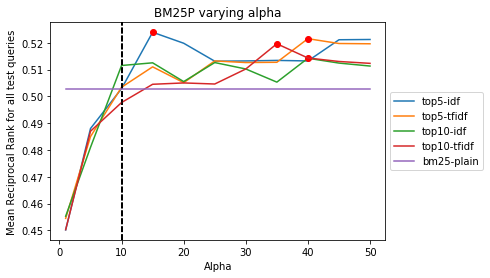

In [15]:
plot_and_sort(baseTypes, alphas, metric_dict, "Mean Reciprocal Rank for all test queries")

# Get more metrics from eval file

In [16]:
def getAllMetrics(file):
    """
    The file has a list of metrics per query and "all".
    """
    qidMetricVal = defaultdict(lambda: defaultdict(str))
    with open(file) as inputFile:
        for line in inputFile:
            metric_dict = qidMetricVal[line.split()[1]]
            metric_dict[line.split()[0]] = line.split()[2]
    return qidMetricVal

In [26]:
all_metrics_dict = getAllMetrics(dirEval+"BM25P-CLEF-FR-top5-idf-2005-2006-queries-p-10-alpha-15.res.eval")
len(all_metrics_dict.keys())
all_metrics_dict.keys()
all_metrics_dict["all"]

defaultdict(str,
            {'11pt_avg': '0.2384',
             'G': '0.1865',
             'P_10': '0.3121',
             'P_100': '0.1430',
             'P_1000': '0.0274',
             'P_15': '0.2848',
             'P_20': '0.2631',
             'P_200': '0.0919',
             'P_30': '0.2347',
             'P_5': '0.3475',
             'P_500': '0.0479',
             'Rndcg': '0.3569',
             'Rprec': '0.2331',
             'Rprec_mult_0.20': '0.3344',
             'Rprec_mult_0.40': '0.3004',
             'Rprec_mult_0.60': '0.2691',
             'Rprec_mult_0.80': '0.2522',
             'Rprec_mult_1.00': '0.2331',
             'Rprec_mult_1.20': '0.2182',
             'Rprec_mult_1.40': '0.2060',
             'Rprec_mult_1.60': '0.1932',
             'Rprec_mult_1.80': '0.1817',
             'Rprec_mult_2.00': '0.1722',
             'binG': '0.1865',
             'bpref': '0.2402',
             'gm_bpref': '0.0233',
             'gm_map': '0.0367',
             'infAP': 

In [27]:
def filterOneMetric(dirEval, metric_name):
    metric_dict = defaultdict()
    for filename in os.listdir(dirEval):
        if ending in filename:
    #         print(filename)
            name_items = filename.split("-")
            baseType = name_items[3]+"-"+name_items[4]
            alpha = filename.split(".")[0].split("-")[11]
            all_metrics_dict = getAllMetrics(dirEval+filename)
            metric_dict[(baseType, int(alpha))] = float(all_metrics_dict["all"][metric_name])
    return metric_dict

In [28]:
a = filterOneMetric(dirEval, "map")
a

defaultdict(None,
            {('bm25-plain', 0): 0.2397,
             ('bm25-plain', 1): 0.2397,
             ('top10-idf', 1): 0.1829,
             ('top10-idf', 5): 0.2226,
             ('top10-idf', 10): 0.2308,
             ('top10-idf', 15): 0.2335,
             ('top10-idf', 20): 0.2317,
             ('top10-idf', 25): 0.2328,
             ('top10-idf', 30): 0.2326,
             ('top10-idf', 35): 0.2327,
             ('top10-idf', 40): 0.2407,
             ('top10-idf', 45): 0.2398,
             ('top10-idf', 50): 0.2391,
             ('top10-tfidf', 1): 0.1898,
             ('top10-tfidf', 5): 0.2306,
             ('top10-tfidf', 10): 0.2391,
             ('top10-tfidf', 15): 0.2413,
             ('top10-tfidf', 20): 0.2408,
             ('top10-tfidf', 25): 0.2396,
             ('top10-tfidf', 30): 0.2412,
             ('top10-tfidf', 35): 0.2497,
             ('top10-tfidf', 40): 0.2467,
             ('top10-tfidf', 45): 0.2455,
             ('top10-tfidf', 50): 0.2447,
    

[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] [0.1636, 0.2033, 0.2153, 0.2213, 0.2237, 0.2239, 0.2237, 0.2237, 0.2236, 0.2329, 0.2322]
[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] [0.1861, 0.226, 0.2358, 0.2374, 0.237, 0.2381, 0.2361, 0.2366, 0.2444, 0.2434, 0.2423]
[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] [0.1829, 0.2226, 0.2308, 0.2335, 0.2317, 0.2328, 0.2326, 0.2327, 0.2407, 0.2398, 0.2391]
[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] [0.1898, 0.2306, 0.2391, 0.2413, 0.2408, 0.2396, 0.2412, 0.2497, 0.2467, 0.2455, 0.2447]
[0.2397, 0.2397, 0.2397, 0.2397, 0.2397, 0.2397, 0.2397, 0.2397, 0.2397, 0.2397, 0.2397]


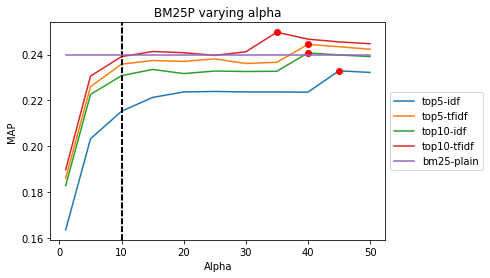

In [23]:
plot_and_sort(baseTypes, alphas, a, "MAP")

### Statistical significance for MRR values

In [55]:
def two_sample_ttest_ind(a,b):
    return stats.ttest_ind(a, b, equal_var=False)

def two_sample_ttest_rel(a,b):
    return stats.ttest_rel(a, b)

In [56]:
def check_statistical_significance(all_metrics_dict_A, all_metrics_dict_B, metric):
    """
    between 2 means of a specific metric
    e.g. compare MAP / RR for top5-idf and bm25-plain for alpha 10
    
    """
    metric_values_per_query_A = []
    metric_values_per_query_B = []
    
    for k in all_metrics_dict_A.keys():
        if k!="all":
            metric_values_per_query_A.append(float(all_metrics_dict_A[k][metric]))
            metric_values_per_query_B.append(float(all_metrics_dict_B[k][metric]))
    
#     print(metric_values_per_query_A)
#     print(metric_values_per_query_B)
    with open("/home/muntean/compare_2_distrib.txt","w") as f:
        f.write(",".join([str(x) for x in metric_values_per_query_A]) + "\n")
        f.write(",".join([str(x) for x in metric_values_per_query_B]))

    print(np.mean(metric_values_per_query_A))
    print(np.mean(metric_values_per_query_B))
    print(two_sample_ttest_rel(metric_values_per_query_A, metric_values_per_query_B))

In [83]:
base_type_A = "top5-idf"
alpha_A = "15"
base_type_B = "bm25-plain"
alpha_B = "1"

all_metrics_dict_A = getAllMetrics(dirEval+"BM25P-CLEF-FR-"+base_type_A+"-2005-2006-queries-p-10-alpha-"+alpha_A+".res.eval")
all_metrics_dict_B = getAllMetrics(dirEval+"BM25P-CLEF-FR-"+base_type_B+"-2005-2006-queries-p-10-alpha-"+alpha_B+".res.eval")

In [84]:
# print(all_metrics_dict_A.keys()) 
# print(all_metrics_dict_B.keys()) 
check_statistical_significance(all_metrics_dict_A, all_metrics_dict_B, "recip_rank")

0.523923232323
0.502822222222
Ttest_relResult(statistic=0.83133034432826269, pvalue=0.40780801072612261)


In [85]:
check_statistical_significance(all_metrics_dict_A, all_metrics_dict_B, "map")

0.221314141414
0.239667676768
Ttest_relResult(statistic=-2.551162538154423, pvalue=0.01228317038086865)


In [79]:
# https://rasbt.github.io/mlxtend/installation/
# p_value = permutation_test(a, b,
#                   method='approximate',
#                   num_rounds=10000,
#                   seed=10)
# print(p_value)

# 0.6237

In [52]:
### new comparison
base_type_A = "top10-tfidf"
alpha_A = "10"

all_metrics_dict_A = getAllMetrics(dirEval+"BM25P-CLEF-FR-"+base_type_A+"-2005-2006-queries-p-10-alpha-"+alpha_A+".res.eval")

In [53]:
check_statistical_significance(all_metrics_dict_A, all_metrics_dict_B, "recip_rank")
# not even a 2 point difference is statistically significant :O

0.497694949495
0.502822222222
Ttest_relResult(statistic=-0.4866698339245451, pvalue=0.62757897723713219)
